# Cluster analysis t-test

This file is part of the Comparative analysis of tissue-specific genes in maize based on machine learning models: CNN performs technically best, LightGBM performs biologically sound project.

### Input files:
1. *Filtered_Maize_expression.csv*
2. *shap_kmeans.pkl*

### Output files:
1. *Fig_t.svg*
2. *rand_gauss.pkl*
 
### Table of contents:
1. [Import Modules](#1.-Import-Modules)  
2. [Set static paths](#2.-Set-static-paths)  
3. [Load files](#3.-Load-files)  
    3.1 [Load test data](#3.1-Load-test-data)  
    3.2 [Load kmeans](#3.1-Load-kmeans)  
4. [Process data](#4.-Process-data)  
    4.1 [Transform data](#4.1-Transform-data)  
5. [Measure clustering](#5.-Measure-clustering)  
    5.1 [Calculate kmeans](#5.1-Calculate-kmeans)  
    5.2 [Transform data](#4.1-Transform-data)  
6. [Create gaussian](#6.-Create-gaussian)  
    6.1 [Calculate mean](#6.1-Calculate-mean)  
    6.2 [Calculate variance](#6.2-Calculate-variance)  
    6.3 [Build gaussian](#6.3-Build-gaussian)  
    6.4 [Plot gaussian](#6.4-Plot-gaussian)  
7. [Save out results](#7.-Save-out-results)  

## 1. Import Modules

In [82]:
import pandas as pd
import numpy as np
import pickle

In [83]:
import os
util_path = '../notebooks'
os.chdir(util_path)
gtex_tmm = pd.read_csv('2Filtered_Maize_expression.csv', index_col=0)

In [84]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(gtex_tmm,test_size = 0.2)

In [85]:
import os

In [86]:
util_path = '../src'
os.chdir(util_path)

In [87]:
import pandas as pd
import pickle
from tqdm import tqdm
from cluster import get_random_gene_df, get_kmeans_dict, get_p_value
from vis import plot_umap
from modelling.cnn import log_transform
import statistics 
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Set static paths

In [88]:
data_type = "imbalanced"
data_dir = "../data/"

In [89]:
input_dir = data_dir + "processed/"
gene_dir = data_dir + "gene_lists/"
fig_dir = "../figures/"
output_dir = data_dir + "proc/"

## 3. Load files

#### 3.1 Load test data

In [90]:
test_data = test

#### 3.2 Load kmeans

In [91]:
## Test data
with open(input_dir + "shap_kmeans.pkl", "rb") as f:
    shap_kmeans = pickle.load(f)

## 4. Process data

#### 4.1 Transform data

In [92]:
test_data = log_transform(test_data, label=True)

## 5. Measure clustering

#### 5.1 Calculate kmeans

In [93]:
random_list = []
for i in tqdm(range(10)):
    random_df = get_random_gene_df(test_data, 2423)
    rand_shap_umap_df = plot_umap(
        random_df,
        "Fig_t",
        fig_dir,
        label_col="tissue",
        seed=42,
        save_plot=False
    )
    random_list.append(rand_shap_umap_df)

  0%|          | 0/10 [00:00<?, ?it/s]/root/GradientExplainer-RNAseq-master_wzj/src/cluster.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_df_rand["tissue"] = labels
 10%|█         | 1/10 [00:01<00:12,  1.39s/it]/root/GradientExplainer-RNAseq-master_wzj/src/cluster.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_df_rand["tissue"] = labels
 20%|██        | 2/10 [00:02<00:11,  1.38s/it]/root/GradientExplainer-RNAseq-master_wzj/src/cluster.py:59: SettingWithCopyWarning: 
A value is trying 

In [94]:
random_shap_dict = {}
kmeans_dict = {}
for i in range(10):
    random_shap_dict[i]=[]

In [95]:
for x in tqdm(range(10)):
    for i in range(10):
        random_shap_dict[i].append(get_kmeans_dict(random_list[i], "tissue"))

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


In [96]:
for i in range(10):
    kmeans_dict[f"Random SHAP {i}"] = random_shap_dict[i]

In [97]:
random_shap_results = []
for i in range(10):
    random_shap_results.append(pd.DataFrame.from_dict(kmeans_dict[f"Random SHAP {i}"]))

In [98]:
rand_mean = []
for i in range(10):
    rand_mean.append(random_shap_results[i]["V-Measure"].mean())

## 6. Create gaussian

#### 6.1 Calculate mean

In [99]:
overall_mean = statistics.mean(rand_mean)

#### 6.2 Calculate variance

In [100]:
var_list = []
for i in range(10):
    var_list.append(random_shap_results[i]["V-Measure"].var())

In [101]:
mean_var = statistics.mean(var_list)

In [102]:
std_dev = math.sqrt(mean_var)

#### 6.3 Build gaussian

In [103]:
rand_gauss = np.random.normal(loc=overall_mean, scale=std_dev, size=10000)

In [104]:
rand_gauss = pd.DataFrame(rand_gauss, columns=["V-Measure"])

#### 6.4 Plot gaussian

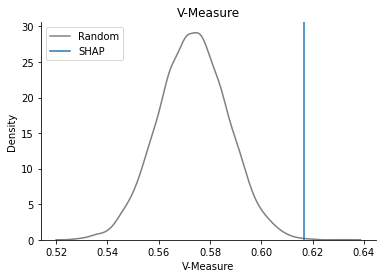

In [105]:
metric = "V-Measure"
sns.kdeplot(rand_gauss[metric], label="Random", color="gray").set_title(metric)
plt.axvline(shap_kmeans[metric].mean(), label="SHAP")
plt.legend()
sns.despine()
file_path = fig_dir+"suppfig8.svg"
plt.savefig(file_path)

## 7. Save out results

In [106]:
rand_gauss.to_pickle("rand_gauss.pkl")